# "Análisis de Anomalías"

##*Jose Fernando Zea y Fernando López-Torrijos*


6 de abril de 2021

*Adaptado a google colab por Alejandro Herrera López*


In [ ]:
# activate R magic
%%capture
%load_ext rpy2.ipython

In [ ]:
%%capture
%%R
library(ggplot2)
library(reticulate)
matplotlib <- import('matplotlib')
matplotlib$use('Agg', force = TRUE)

 Prólogo

En español se define anomalía como "Desviación o discrepancia de una regla o de un uso". En inglés lo definen como "something that is unusual enough to be noticeable or seem strange". Según Aggarwal (2017) un outlier es un punto que difiere significativamente de los demás puntos o si difiere del mecanismo generador de los datos.

Podría hablarse de muchos tipos de anomalías dentro de un conjunto de datos:

- Datos faltantes

- Valores no probables (¿error de digitación?)

- Valores atípicos

- No respuesta

- Formato incorrecto

Algunos definen los datos atípicos como datos muy *grandes* o muy *pequeños* comparados con el grueso del conjunto de datos. Son observaciones con un comportamiento extraño porque toman valores que no se esperan. Pero esos datos es mejor denominarlos *valores extremos*.

Este documento se centra en las *anomalías*, distinguiendo éstas del ruido aleatorio, que también puede generar algunos **valores atípicos**. La separación entre ruido aleatorio y dato anómalo no es siempre clara.

El dato en color rojo de la Figura 1 está dentro de la tendencia de los demás datos, pero es significativamente grande respecto a los restantes mirado desde el punto de vista de la variable $x$. Desde el punto de vista de la variable $y$, podría tratarse de un valor indistingible. Podría tratarse de un dato aislado alto pero válido o podría tratarse de un dato anómalo.

El dato en color rojo de la Figura 2 está fuera de la tendencia. Dentro de una mirada a sólo la variable $x$, no resalta. Dentro de solo la variable $y$ tampoco. Sólo en la dimensión conjunta $x,y$ se observa su anomalía.

El dato en color rojo de la Figura 3 se presentaría tanto en $x$ como un dato anómalo en medio de dos conglomerados de datos. Respecto a la variable $y$, tal vez sería indistinguible. Es un dato anómalo desde la dimensión conjunta $x,y$.

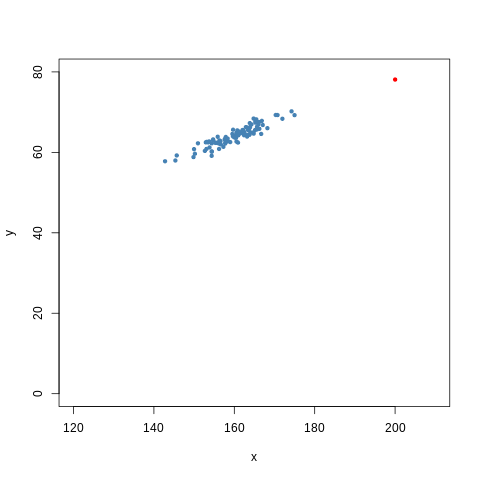

In [ ]:
%%R
x <- rnorm(n = 100, mean = 160, sd = 6)
y <- 0.1 + 0.4 * x + rnorm(n = 100, mean = 0, sd = 1)
plot(x, y, pch = 20, xlim = c(120, 210), ylim = c(0, 80), col = 'steelblue')
points(200, 0.1 + 0.4 * 195, col = "red", pch = 20)

**Figure 1: Dato extremo**

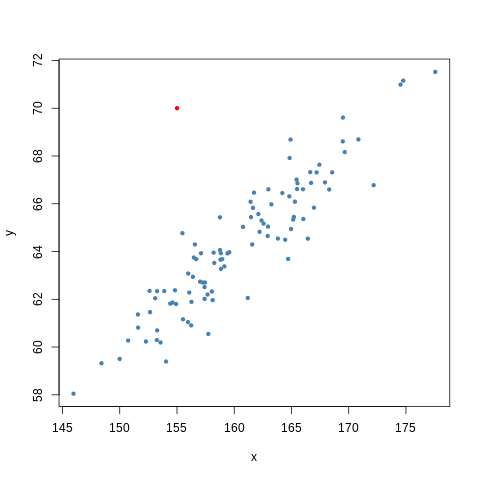

In [ ]:
%%R
x <- rnorm(n = 100, mean = 160, sd = 6)
y <- 0.1 + 0.4 * x + rnorm(n = 100, mean = 0, sd = 1)
plot(x, y, pch = 20, col = 'steelblue')
points(155, 70, col = "red", pch = 20)

**Figure 2: Dato fuera de la tendencia**

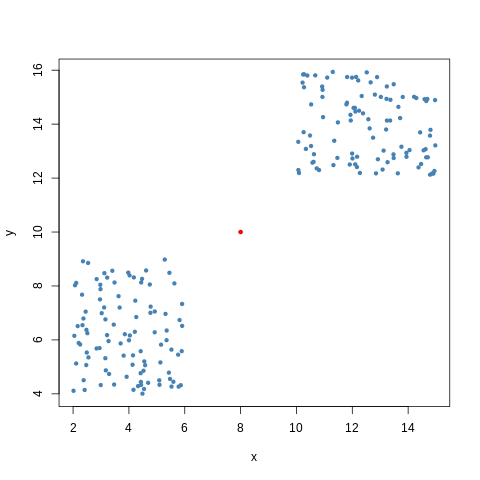

In [ ]:
%%R
x1 <- runif(n = 100, min = 2, max = 6)
y1 <- runif(n = 100, min = 4, max = 9)
x2 <- runif(n = 100, min = 10, max = 15)
y2 <- runif(n = 100, min = 12, max = 16)
x3 <- 8
y3 <- 10
x <- c(x1, x2, x3)
y <- c(y1, y2, y3)
plot(x, y, pch = 20, col = 'steelblue')
points(x3, y3, pch = 20, col = "red")

**Figure 3: Dato intermedio**

# Aplicaciones

* Sistema de detección de intrusiones: transacciones bancarías anómalas (demasiados movimientos en una cuenta), actividad inusual en una red de telefonía móvil.  
* Fraude de tarjeta de crédito: localizaciones, movimientos inusuales.
Eventos obtenidos a partir de sensores: comportamientos extraños que pueden estar asociados al mal funcionamiento de un dispositivo.  
* Diagnóstico médico: imágenes de resonancia magnética, tomografías, electrocardiogramas pueden estar asociadas a detección de enfermedades.  
* Incumplimiento de la ley: reclamaciones de seguros, actividad de trading, movimientos financieros.  
* Ciencias de la tierra: anomalías ambientales, uso del suelo, condiciones ambientales anómalas.  
* Procesamiento de imágenes: Eliminación de la pixelación que impide una mejor interpretación de una imagen.

# Presentación de las técnicas tradicionales o más usuales.

## Análisis variable a variable.

El primer caso que se trabaja es la definición de un dato anómalo cuando se trabaja con una única variable a la vez.

El primer contexto en el que se encuentran es en el diagrama de caja o boxplot.

In [ ]:
%%R
datos <- c(103.1, 82.1, 106.2, 100.9, 91.8, 96.1, 126.9, 119.8, 93.1, 86.8, 
           75.2, 93, 82.3, 94.8, 64.2, 105.3, 108, 86.3, 81.8, 179.1, 138.1, 
           92.5, 66.3, 66.6, 142.2, 96.5, 74.8, 95.4, 100.1, 81.9, 112, 116.8,
           103.2, 66.1, 60.4, 78.7)

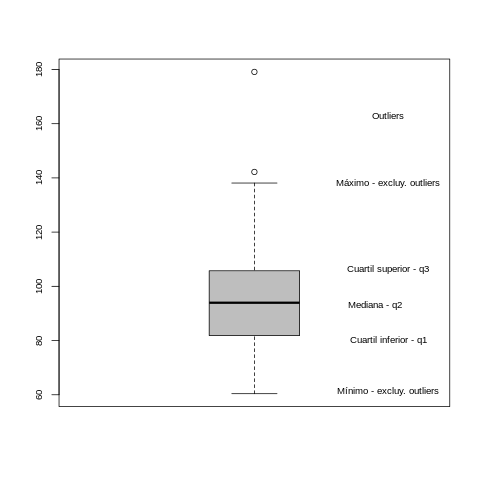

In [ ]:
%%R
g <- boxplot(datos, col = 'gray', ylab = '', cex.axis = 0.8, cex.lab = 0.8, outline = T, boxwex = 0.5)
text(x = 1.37, y = g$stats[nrow(g$stats),] - 32, 'Cuartil superior - q3', cex = 0.8)
text(x = 1.37, y = g$stats[nrow(g$stats),] - 58, 'Cuartil inferior - q1', cex = 0.8)
text(x = 1.37, y = g$stats[nrow(g$stats),] - 45, 'Mediana - q2         ', cex = 0.8)
text(x = 1.37, y = g$stats[nrow(g$stats),] + 25, 'Outliers', cex = 0.8)
text(x = 1.37, y = g$stats[nrow(g$stats),] + 0, 'Máximo - excluy. outliers', cex = 0.8)
text(x = 1.37, y = g$stats[nrow(g$stats),] - 77, 'Mínimo - excluy. outliers', cex = 0.8)

**Figure 4: Elementos de un diagrama de caja**

El Diagrama de caja se construye con base en los cuartiles (ver Figura 4):

Cuartil 1 (q1): valor a partir del cual el 25% de los datos tienen un valor menor a éste.  O leído al revés, el valor a partir del cual el 75% de los datos tienen un valor mayor a éste.

Ojo. El 25% hace referencia a la cantidad de datos, no a sus valores.

Cuartil 2 (q2): valor a partir del cual el 50% de los datos tienen un valor menor. Se denomina también mediana. Es un valor robusto frente a datos extremos, es decir, no se afecta por la presencia de datos extremos.

Cuartil 3 (q3): valor a partir del cual el 75% de los datos tienen un valor menor a éste. O leído al revés, el valor a partir del cual el 25% de los datos tienen un valor mayor a éste.

Rango intercuartil (RI): La diferencia entre el cuartil 3 y el 1. $RI = q3 - q1$

In [ ]:
%%R
q1 <- round(quantile(datos, .25), 1)
q2 <- round(quantile(datos, .50), 1)
q3 <- round(quantile(datos, .75), 1)
RI <- q3 - q1 

Bajo las reglas de Tukey, un estadístico activo en las décadas del 40 al 80 del siglo XX, y quien popularizó los diagramas de caja, todo dato que está alejado más de $1.5$ veces el $RI$ del cuartil más cercano se dice que es un dato *atípico*. Un dato atípico lo denominan *extremo* si está ubicado a una distancia mayor de $3$ veces el $RI$ del cuartil más cercano y se llama *moderado* en caso contrario.

In [ ]:
%%R
atipico_extremo <- c(datos[datos > q3 + 3*RI], datos[datos < q1 - 3*RI])
atipico_moderado <- c(datos[datos > q3 + 1.5*RI], datos[datos < q1 - 1.5*RI])
atipico_moderado <- atipico_moderado[!(atipico_moderado %in% atipico_extremo)]

Sobre el conjunto de datos que generó el diagrama del ejemplo 4, hay dos círculos que reflejan los datos atípicos.

Atípico moderado: `r atipico_moderado`

Atípico extremo: `r atipico_extremo`

Los cuartiles de la Figura 4 son: `r q1`, `r q2`, `r q3`

# Regla empírica de Tukey

Tukey en los años 60 construyó una regla para identificar valores extremos en datos con distribuciones gausianas o normales, para esto se basó en el uso de dos cantidades conocidas como bisagras o bigotes (hinges/whiskers en la lieratura anglosajona). 

El bigote inferior se calcula como $LW = q_{1} - k \times RI$ Es decir, el bigote inferior (lower whisker) se calcula como el percentil 25 (o primer cuartil) menos k veces el rango intercuartílico (RI). Tukey propuso como valor de k = 1,5.

SI LW es menor al mínimo de los datos el valor que finalmente se deja como bigote inferior es el mínimo. Es decir, $$LW = max(min(x),  q_{1} - k \times RI)$$

El bigote superior se calcula como: $$UW = min(max(x), q_{3} + k \times RI)$$

In [ ]:
%%R
RI <- qnorm(0.75) - qnorm(0.25)
lw <- qnorm(0.25) - 1.5*RI
uw <- qnorm(0.75) + 1.5*RI
p <- round(pnorm(lw) + pnorm(uw, lower.tail = F), 6)

$$
y(\lambda)=
\begin{cases}
\frac{x^\lambda - 1}{\lambda}, \text{Sí } \lambda \neq 0\\
log(\lambda), \text{Sí}  \lambda = 0
\end{cases}
$$

Ilustraremos la transformación de Box - Cox con un ejemplo en python:

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from scipy.stats import t, zscore
import random

Simularemos una distribución asimétrica a la izquierda:


In [ ]:
# Gnerar una distribución asimétrica (una exponencial en particular)
np.random.seed(0)
x = np.random.exponential(size = 1000)
np.mean(x), np.var(x)

(1.003540208760709, 1.0590341339276639)

In [ ]:
# Transformación de Box-Cox (Dupla: arreglo de valores transformados y lambda)
y, fitted_lambda = stats.boxcox(x)

Se compara la distribución original con la transformada mediante Box - Cox

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


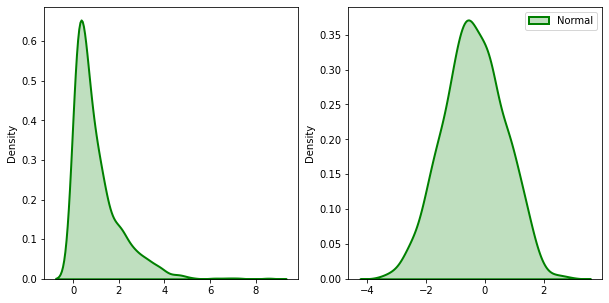

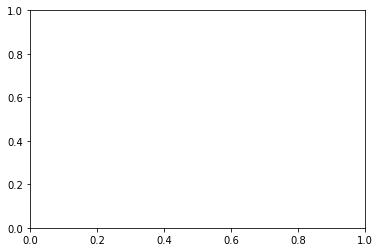

In [ ]:
# crear ejes para el gráfico: 1 fila 2 columnas
fig, ax = plt.subplots(1, 2)
# graficando la variable en su manera original y luego de transformada
sns.distplot(x, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
  
sns.distplot(y, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
  
# Anadiendo leyenda a los gráficos
plt.legend(loc = "upper right")
  
# re-escalando los subplots
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()
# Se restituyen los valores a 1 fila 1 columna para los plots
fig, ax = plt.subplots(1, 1)

In [ ]:
print(f"Lambda utilizado para la transformación: {fitted_lambda}")

Lambda utilizado para la transformación: 0.2420131978174143


**Ejercicio**: se ilustra la identificación de atípicos con la base de datos iris. Se utiliza para la demostración la variable Sepal.Length. Dada la aparentemente normalidad de los datos se detectarán directamente los *outliers* mediante la regla de Tukey.

Python no tiene una función para su cálculo, así que se crea la función *fivenum* para que genere calcule y entregue los cinco números de Tukey: bigote inferior, primer cuartil, mediana, tercer cuartil y bigote superior, para una lista, arreglo univariado de numpy o serie de pandas.


In [ ]:
def fivenum(x, range = 1.5, nan_remove = True):
    """Devuelve los cinco números de Tukey (mínimo, bigote inferior, mediana,
    bigote superior, maximo) para una lista, arreglo univariado de numpy o serie de pandas"""
    
    if(isinstance(x, list)):
        x = np.array(x)
    try:
        np.sum(x)
    except TypeError:
        print('Error: debe proveer una lista o un arreglo de sólo números')
    if(nan_remove == True):
        y = x[~np.isnan(x)]    
        q1 = np.percentile(y, 25)
        q3 = np.percentile(y,75)
        md = np.median(y)
        RI = q3-q1
        lower_whisker = q1 - 1.5 * RI
        upper_whisker = q3 + 1.5 * RI
        lower_whisker = np.max([lower_whisker, np.min(y)])
        upper_whisker = np.min([upper_whisker, np.max(y)])
        
    else:
        q1 = np.percentile(x, 25)
        q3 = np.percentile(x,75)
        md = np.median(x)
        RI = q3-q1
        lower_whisker = q1 - 1.5 * RI
        upper_whisker = q3 + 1.5 * RI
        lower_whisker = np.max([lower_whisker, np.min(x)])
        upper_whisker = np.min([upper_whisker, np.max(x)])
    
    salida = np.array([lower_whisker, q1, md, q3, upper_whisker])       
    return salida


Se cargan los datos para el ejemplo:


In [ ]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris['target']
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length',
       'petal_width', 'species']

Se calculan los 5 números de Tukey y se guardan en la variable *fnums*:

In [ ]:
fnums = fivenum(iris_df.sepal_width)
fnums

array([2.05, 2.8 , 3.  , 3.3 , 4.05])

Se crea una nueva variable denominada *outlier_sw* donde se almacena si es o no es un *outlier*. Se imprime el conteo.

In [ ]:
iris_df['outlier_sw'] = iris_df['sepal_width'].apply(lambda x: 'outlier' if (x < fnums[0]) | (x > fnums[4]) else 'no_outlier')
iris_df.outlier_sw.value_counts()

no_outlier    146
outlier         4
Name: outlier_sw, dtype: int64

**Ejemplo de una variable sesgada**

Detectar los *outliers* de la variable *Income* de base de datos de empresas Lucy.

In [ ]:
Lucy = pd.read_csv("Lucy.csv")

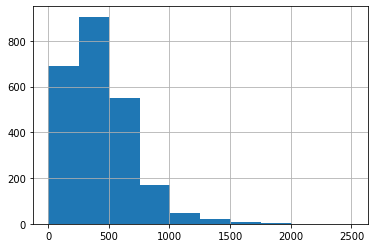

In [ ]:
Lucy.Income.hist()
plt.show()

Se evidencia que la distribución del ingreso es muy asimétrica a la derecha, por lo tanto se aplica la transformación de Box-Cox y se almacena en la variable *Income_bc*:

In [ ]:
#  (Dupla: arreglo de valores transformados y lambda)
y_income_bc, fitted_lambda_income = stats.boxcox(Lucy.Income)
Lucy['Income_bc'] = y_income_bc
Lucy.head()

,ID,Ubication,Level,Zone,Income,Employees,Taxes,SPAM,Income_bc
0,AB001,c1k1,Small,A,281,41,3.0,no,18.293605
1,AB002,c1k2,Small,A,329,19,4.0,yes,19.521134
2,AB003,c1k3,Small,A,405,68,7.0,no,21.248675
3,AB004,c1k4,Small,A,360,89,5.0,no,20.253834
4,AB005,c1k5,Small,A,391,91,7.0,yes,20.947118


El valor de lambda considerado por parte de la función *stats.boxcox* es: 

In [ ]:
fitted_lambda_income

0.3589008867008163

Se guardan los cinco números de Tukey en la variable *fn_income_bc*:


In [ ]:
fn_income_bc = fivenum(Lucy.Income_bc)
fn_income_bc

array([ 5.34786971, 16.8315778 , 20.92531509, 24.48738319, 35.97109128])

Se crea una nueva variable denominada *outlier_Income* donde se almacena si es un outlier. Se imprime el conteo.

In [ ]:
Lucy['outlier_Income'] = Lucy['Income_bc'].apply(lambda x: 'outlier' if (x < fn_income_bc[0]) | (x > fn_income_bc[4]) else 'no_outlier')
Lucy.outlier_Income.value_counts()

no_outlier    2379
outlier         17
Name: outlier_Income, dtype: int64

**Ejercicio:**

Detectar los valores extremos de la variable *Employees*.